In [ ]:
!pip install quantile-forest
!pip install dill

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
sns.set_style('whitegrid')
import pandas as pd
from joblib import Parallel, delayed
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from src import tqf 
from src import gendata
from src.gendata import sig
from src.qmem import energy_distance, quantile

(1312, 2)


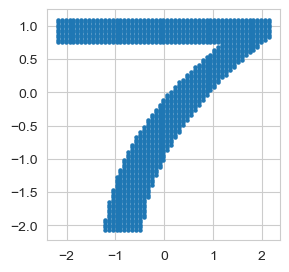

In [4]:
cdat = gendata.create_character_data('7')
print(cdat.shape)
plt.figure(figsize=(3,3))
plt.scatter(cdat[:, 0], cdat[:, 1], s=5)

In [19]:
try:
    del X, Y
except:
    pass
p1 = 2
p2 = 3
X, Y = gendata.create_c(size=20000, seed=88, dim_used=p1, dim_useless=p2, char='7')
X.shape, Y.shape

((20000, 5), (20000, 2))

In [20]:
%%time
try:
    del model
    import gc
    gc.collect()
except:
    pass

model = tqf.TQF()
model.fit(X=X, Y=Y, seed=477, n_augment=20, n_jobs=5, n_rot=10,
          T_rff=[0.3, 0.4],
          qrf_params={'n_estimators': 120, 'min_samples_leaf': 100})

CPU times: total: 46min 3s
Wall time: 9min 54s


In [21]:
model.y_ws

(array([0.18094738, 0.36509742, 0.55733655, 0.75673468, 0.9713945 ,
        1.20877544, 1.48190484, 1.81776564, 2.28895425]),
 array([0.3, 0.4]))

In [22]:
model.q_predictor[1].feature_importances_

array([0.23291105, 0.23742552, 0.04263872, 0.04301725, 0.0447595 ,
       0.0079572 , 0.0190757 , 0.08199162, 0.01285179, 0.00909308,
       0.01189176, 0.00982192, 0.01093685, 0.00775424, 0.01468162,
       0.02167468, 0.00834497, 0.09923566, 0.01755948, 0.01173513,
       0.00803168, 0.01134273, 0.00850328, 0.0071344 , 0.01963018])

<BarContainer object of 25 artists>

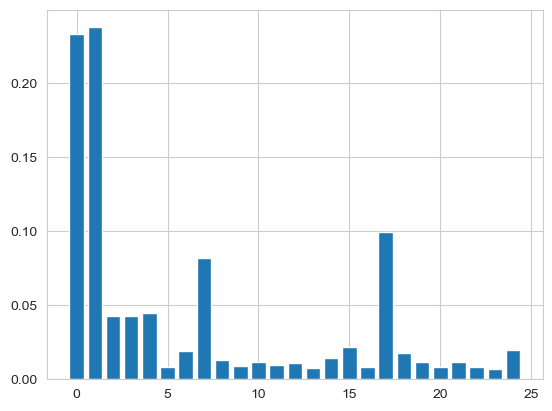

In [23]:
plt.bar(x=np.arange(len(model.q_predictor[1].feature_importances_)), height=model.q_predictor[1].feature_importances_)

In [24]:
np.array([tree.get_depth() for tree in model.q_predictor[1].estimators_])

array([22, 29, 22, 25, 21, 25, 22, 26, 25, 23, 24, 24, 26, 25, 21, 24, 22,
       25, 22, 23, 23, 24, 23, 23, 23, 24, 21, 24, 23, 23, 21, 22, 24, 22,
       23, 25, 22, 23, 22, 25, 23, 22, 23, 24, 25, 24, 23, 23, 24, 22, 22,
       25, 22, 23, 25, 22, 25, 20, 26, 24, 23, 28, 21, 23, 23, 23, 23, 23,
       25, 23, 23, 22, 25, 22, 23, 25, 22, 24, 25, 25, 23, 22, 23, 22, 24,
       23, 24, 23, 24, 21, 24, 22, 22, 25, 26, 22, 21, 24, 24, 25, 21, 24,
       22, 24, 24, 22, 23, 22, 22, 24, 23, 27, 22, 21, 24, 23, 24, 21, 21,
       27])

In [25]:
np.array([tree.get_n_leaves() for tree in model.q_predictor[1].estimators_])

array([1942, 1926, 1927, 1941, 1925, 1933, 1929, 1922, 1922, 1916, 1937,
       1925, 1930, 1940, 1928, 1923, 1931, 1919, 1920, 1914, 1932, 1925,
       1923, 1923, 1945, 1929, 1955, 1945, 1953, 1921, 1946, 1931, 1924,
       1931, 1932, 1922, 1925, 1929, 1932, 1919, 1924, 1928, 1928, 1921,
       1935, 1946, 1942, 1935, 1941, 1916, 1924, 1941, 1934, 1939, 1932,
       1925, 1926, 1937, 1919, 1931, 1930, 1931, 1932, 1921, 1940, 1929,
       1922, 1942, 1942, 1901, 1940, 1931, 1921, 1908, 1936, 1933, 1929,
       1928, 1933, 1941, 1905, 1939, 1925, 1925, 1954, 1906, 1929, 1924,
       1941, 1951, 1917, 1925, 1924, 1926, 1941, 1923, 1921, 1923, 1918,
       1926, 1915, 1927, 1932, 1906, 1930, 1929, 1919, 1910, 1943, 1936,
       1916, 1939, 1933, 1928, 1939, 1930, 1936, 1943, 1918, 1926])

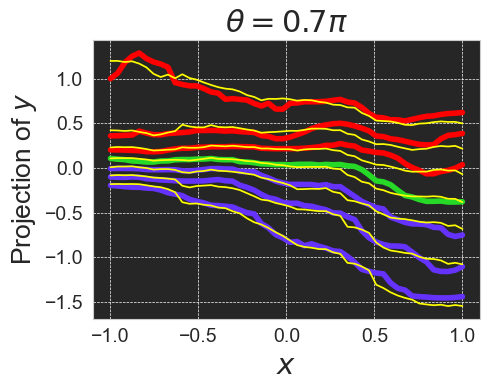

CPU times: total: 1.45 s
Wall time: 1.5 s


In [ ]:
%%time
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_facecolor((0.15, 0.15, 0.15))

theta = np.pi * 0.7
xs = np.linspace(-1., 1., 50)
qs = np.linspace(0.2, 0.8, 7)
K = len(qs)

_idx = lambda x: np.argsort(np.linalg.norm(X[:, : p1] - np.array([x] * p1), axis=1))[:400]
_dist = lambda x: np.linalg.norm(X[_idx(x), : p1] - np.array([x] * p1), axis=1)
_med = lambda x: np.median(_dist(x))
_weights = lambda x: np.exp(- (_dist(x) / _med(x))**2)
_Qx = np.asarray([quantile(
         model.y_scaler_whole.transform(Y[_idx(x)]) @ np.array([np.cos(theta), np.sin(theta)]), 
         weight=_weights(x), q=qs
     ) for x in xs])
for i in range(len(qs)):
    plt.plot(
        xs, _Qx[:, i],
        lw=4, color=(0.4, 0.2, 1, 0.99) if i < (K-1)//2 else 'r' if i > (K-1)//2 else (0.15, 0.85, 0.15)
    )

plt.plot(
    xs, model.y_scaler_1d.inverse_transform(
            model.predict_q(
                X_long=np.array([np.r_[[x] * (p1 + p2), 
                                       model.expand_v(v=[np.cos(theta), np.sin(theta)], 
                                                      n_rot=model.n_rot)
                                 ] for x in xs]),
                qs=qs
            ).reshape(-1, 1)
        ).reshape(len(xs), -1)
    , c='yellow', lw=1.25
)

plt.xlabel(r'$x$', fontsize=21)
plt.ylabel(r'Projection of $y$', fontsize=19)
plt.tick_params(labelsize=14)
plt.grid(color='w', ls='--', lw=0.5)
plt.title(r'$\theta={:.1f}\pi$'.format(theta/np.pi), fontsize=22)
plt.tight_layout()
# plt.savefig('fg_c_x_dependence.pdf', dpi=400)
plt.show()

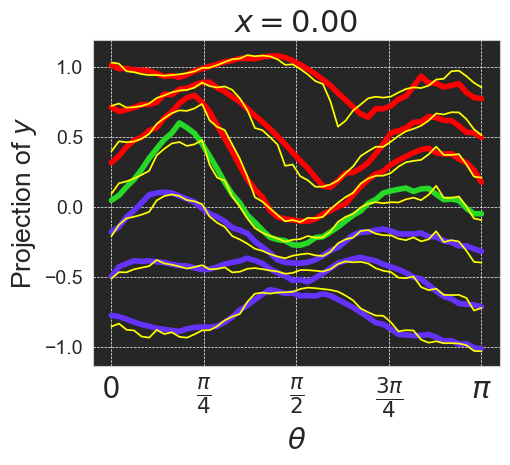

CPU times: total: 1.39 s
Wall time: 1.4 s


In [ ]:
%%time
fig, ax = plt.subplots(figsize=(5.2, 4.75))
ax.set_facecolor((0.15, 0.15, 0.15))

theta_s = np.linspace(0., np.pi, 50)
x = 0.
qs = np.linspace(0.2, 0.8, 7)
K = len(qs)

_Qt = np.asarray([quantile(
         model.y_scaler_whole.transform(Y[_idx(x)]) @ np.array([np.cos(theta), np.sin(theta)]), 
         weight=_weights(x), q=qs
     ) for theta in theta_s])
for i in range(len(qs)):
    plt.plot(
        theta_s, _Qt[:, i],
        lw=4, color=(0.4, 0.2, 1, 0.99) if i < (K-1)//2 else 'r' if i > (K-1)//2 else (0.15, 0.85, 0.15)
    )

plt.plot(
    theta_s, model.y_scaler_1d.inverse_transform(
        model.predict_q(
            X_long=np.array([np.r_[[x] * (p1 + p2), 
                                   model.expand_v(v=[np.cos(theta), np.sin(theta)], 
                                                  n_rot=model.n_rot)
                             ] for theta in theta_s]),
            qs=qs
        ).reshape(-1, 1)
    ).reshape(len(theta_s), len(qs))
    , c='yellow', lw=1.25
)

plt.xlabel(r'$\theta$', fontsize=21)
plt.ylabel(r'Projection of $y$', fontsize=19)
plt.tick_params(labelsize=14)
plt.xticks([0, np.pi/4, np.pi/2, np.pi/4*3, np.pi], ['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'], fontsize=22)
plt.grid(color='w', ls='--', lw=0.5)
plt.title(r'$x={:.2f}$'.format(x), fontsize=22)
plt.tight_layout()
# plt.savefig('fg_c_th_dependence.pdf', dpi=400)
plt.show()

In [28]:
def a2x(a: float):
    return np.log(a / (1. - a)) / 1.5

In [29]:
%%time
w_opt_all = []
points_all = []

for x in [a2x(a) for a in [0.1, 0.3, 0.5, 0.7, 0.9]]:
    w_opt, points = model.predict(seed=1, x=np.array([x] * (p1 + p2)),
                                  n_qs=30, n_directions=30, n_ensemble=20,
                                  n_jobs=4, patience=3)
    w_opt_all += [w_opt]
    points_all += [points]

Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 1740, selection rate: 87.0 %
Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 1605, selection rate: 80.2 %
Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 1895, selection rate: 94.8 %
Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 1805, selection rate: 90.2 %
In

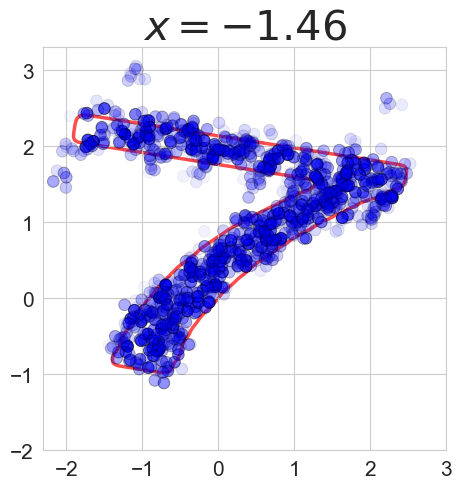

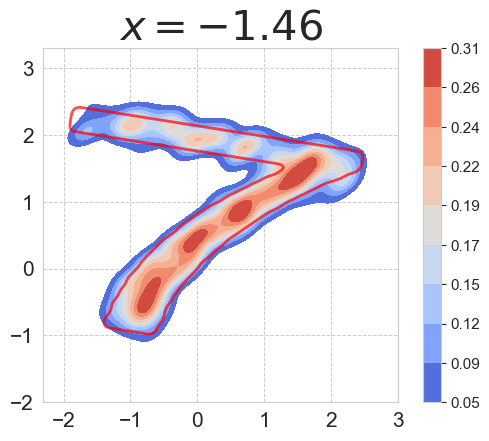

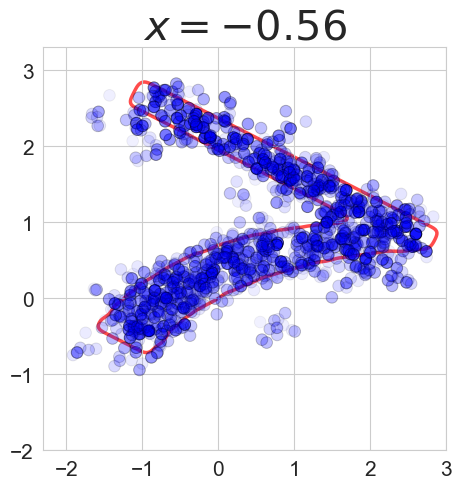

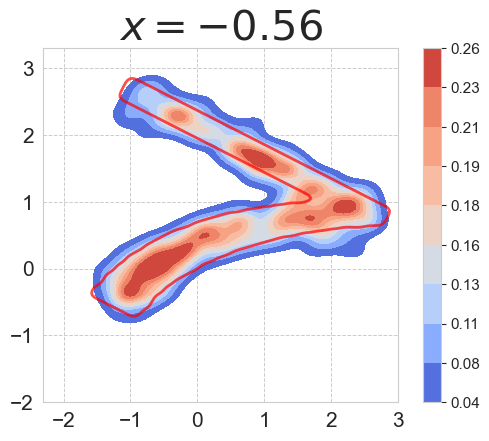

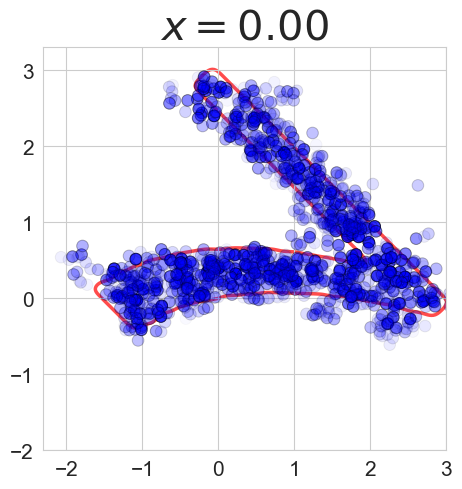

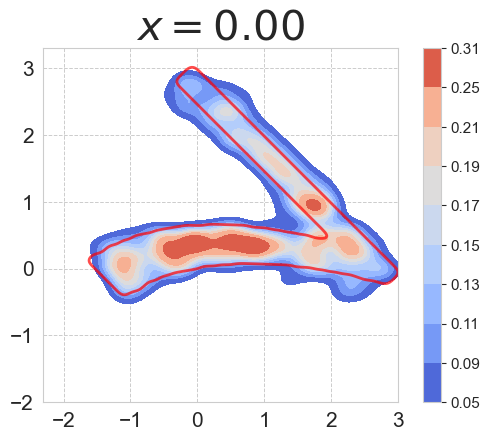

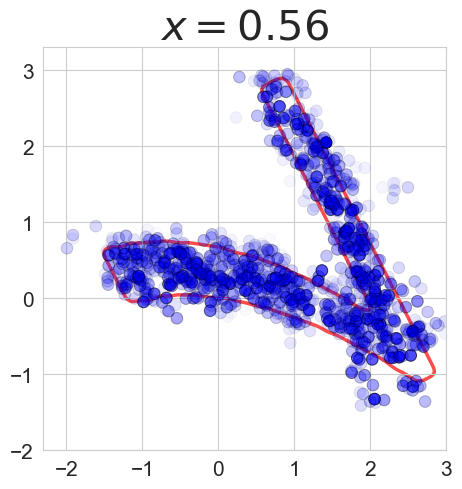

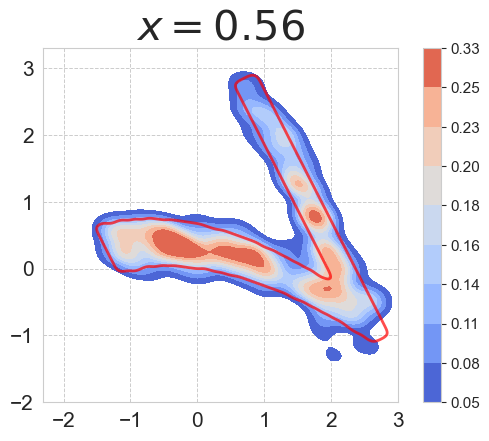

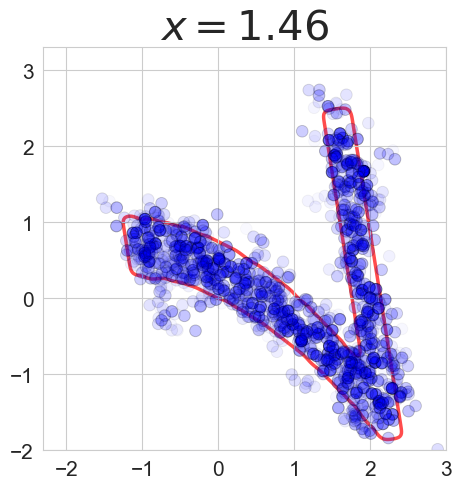

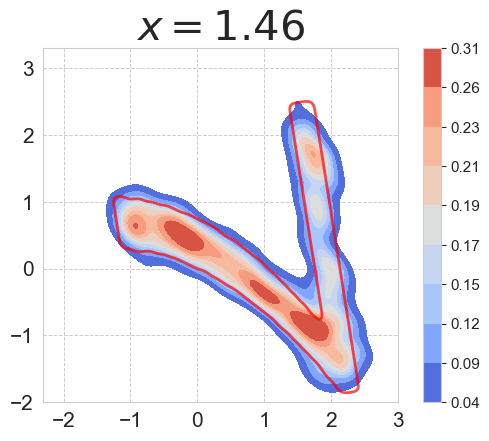

CPU times: total: 16.2 s
Wall time: 16.6 s


In [ ]:
%%time
for j, a in enumerate([0.1, 0.3, 0.5, 0.7, 0.9]):

    w_opt, points = w_opt_all[j], points_all[j]
    x = a2x(a)

    #----------------------------------------------------------

    fig, ax = plt.subplots(figsize=(5, 5))
    Y_true = gendata.create_c_slice(a=a, char_data=cdat)
    sns.kdeplot(
        data=pd.DataFrame(Y_true), x=0, y=1, thresh=0.1, bw_adjust=0.2,
        levels=1, color='r', alpha=0.7, linewidths=2.5, zorder=0, ax=ax
    )
    sns.scatterplot(
        data=pd.DataFrame(points), x=0, y=1, c='b',
        s=70, edgecolor='k', zorder=1, ax=ax, alpha=w_opt/np.max(w_opt)
    )
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-2.3, 3); ax.set_ylim(-2, 3.3)
    plt.title(r'$x={:.2f}$'.format(x), fontsize=30)
    ax.set_xticks(np.arange(-2, 4, 1)); ax.set_yticks(np.arange(-2, 4, 1))
    plt.tick_params(labelsize=15); plt.xlabel(None); plt.ylabel(None)
    plt.tight_layout()
    # plt.savefig('fg_c_raw_{}.pdf'.format(j + 1), dpi=400) #XXXXXXXXXXXXXXXXXXXXXXXXXX
    plt.show()

    #----------------------------------------------------------

    fig, ax = plt.subplots(figsize=(5, 5))
    sns.kdeplot(
        data=pd.DataFrame(points), weights=w_opt, levels=10,
        x=0, y=1, fill=True, zorder=1, ax=ax, bw_adjust=0.5, thresh=0.1, cmap='coolwarm'
    )
    sns.kdeplot(
        data=pd.DataFrame(Y_true), x=0, y=1, thresh=0.1, bw_adjust=0.2,
        levels=1, color='r', alpha=0.7, linewidths=2, zorder=2, ax=ax
    )
    
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-2.3, 3); ax.set_ylim(-2, 3.3)
    ax.grid(True, linewidth=0.7, ls='--')
    ax.set_xticks(np.arange(-2, 4, 1)); ax.set_yticks(np.arange(-2, 4, 1))
    plt.title(r'$x={:.2f}$'.format(x), fontsize=30)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.25)
    im = ax.collections[0]
    cbar = fig.colorbar(im, cax=cax, format='%.2f')
    cbar.ax.tick_params(labelsize=11)
    ax.tick_params(labelsize=15); plt.xlabel(None); plt.ylabel(None)
    ax.set_xlabel(None); ax.set_ylabel(None)
    plt.tight_layout()
    # plt.savefig('fg_c_{}.pdf'.format(j + 1), dpi=400) #XXXXXXXXXXXXXXXXXXXXXXXXXX
    plt.show()

# Comparison with baselines

TQF

In [ ]:
%%time
cdat = gendata.create_character_data(char='7')
res_tqf = []


for k, (a, x) in enumerate([(a, a2x(a)) for a in [0.1, 0.2, 0.3, 0.4, 0.5]]):

    out = []
    Y_true = gendata.create_c_slice(a=a, char_data=cdat)

    for z in range(1000 * (k + 1), 1000 * (k + 1) + 10):

        p1 = 2
        p2 = 3
        X, Y = gendata.create_c(size=20000, seed=z, dim_used=p1, dim_useless=p2, char='7')

        try:
            del model
            import gc
            gc.collect()
        except:
            pass
        model = tqf.TQF()
        model.fit(X=X, Y=Y, seed=z, n_augment=20, n_jobs=12, n_rot=10,
                  T_rff=[0.3, 0.4],
                  qrf_params={'n_estimators': 120, 'min_samples_leaf': 100})

        w_opt, points = model.predict(seed=z, x=np.array([x] * (p1 + p2)), 
                                      n_qs=30, n_directions=30, n_ensemble=20,
                                      n_jobs=10, patience=10, verbose=False)
        ed = energy_distance(X=Y_true, Y=points, weight_Y=w_opt)
        print((a, z, ed), end=' ')
        out.append(ed)

    res_tqf.append([a, np.mean(out), np.std(out)])

res_tqf = np.array(res_tqf)

In [39]:
print(res_tqf)

[[0.1        0.05589015 0.0117786 ]
 [0.2        0.05042004 0.01389788]
 [0.3        0.05995423 0.01885421]
 [0.4        0.06325861 0.0155393 ]
 [0.5        0.06497212 0.01989674]]


Oracle

In [ ]:
%%time
cdat = gendata.create_character_data(char='7')
res_true = []

for a in [0.5]:
    
    Y_true = gendata.create_c_slice(a=a, char_data=cdat)

    def ed(j: int) -> float:

        Y_true_1 = Y_true[np.random.default_rng(j + 123).choice(a=range(len(Y_true)), replace=True, size=len(Y_true))]
        
        return energy_distance(X=Y_true_1, Y=Y_true)

    out = Parallel(n_jobs=4)(delayed(ed)(j) for j in range(100))
    res_true.append([a, np.mean(out), np.std(out)])

res_true = np.array(res_true)
print(res_true)

[[0.5        0.03501197 0.01090455]]
CPU times: total: 375 ms
Wall time: 52.2 s


In [40]:
cdat = gendata.create_character_data(char='7')
Y_true = gendata.create_c_slice(a=a, char_data=cdat)

GMM (n=1)

In [ ]:
%%time
NN = 2000
res_gm_1 = []

for a in [0.5]:
    
    Y_true = gendata.create_c_slice(a=a, char_data=cdat)

    def ed(j: int) -> float:

        Y_true_1 = Y_true[np.random.default_rng(j).choice(a=range(len(Y_true)), replace=True, size=len(Y_true))]
        from sklearn.mixture import BayesianGaussianMixture
        N_COMPONENTS = 1
        gm = BayesianGaussianMixture(n_components=N_COMPONENTS, max_iter=500, 
                                     random_state=j).fit(Y_true_1)
        Y_gm, _ = gm.sample(n_samples=NN)

        return energy_distance(X=Y_true_1, Y=Y_gm)

    out = Parallel(n_jobs=4)(delayed(ed)(j+123) for j in range(100))
    res_gm_1.append([a, np.mean(out), np.std(out)])

res_gm_1 = np.array(res_gm_1)
print(res_gm_1)

[[0.5        0.19600115 0.00698784]]
CPU times: total: 531 ms
Wall time: 1min 49s


GMM (n=2)

In [ ]:
%%time
NN = 2000
res_gm_2 = []

for a in [0.5]:

    Y_true = gendata.create_c_slice(a=a, char_data=cdat)
    
    def ed(j: int) -> float:

        Y_true_1 = Y_true[np.random.default_rng(j).choice(a=range(len(Y_true)), replace=True, size=len(Y_true))]
        from sklearn.mixture import BayesianGaussianMixture
        N_COMPONENTS = 2
        gm = BayesianGaussianMixture(n_components=N_COMPONENTS, max_iter=500, 
                                     random_state=j).fit(Y_true_1)
        Y_gm, _ = gm.sample(n_samples=NN)

        return energy_distance(X=Y_true_1, Y=Y_gm)

    out = Parallel(n_jobs=4)(delayed(ed)(j+123) for j in range(100))
    res_gm_2.append([a, np.mean(out), np.std(out)])

res_gm_2 = np.array(res_gm_2)
print(res_gm_2)

[[0.5        0.11039596 0.02512072]]
CPU times: total: 578 ms
Wall time: 1min 38s


GMM (n=3)

In [ ]:
%%time
NN = 2000
res_gm_3 = []

for a in [0.5]:

    Y_true = gendata.create_c_slice(a=a, char_data=cdat)
    
    def ed(j: int) -> float:

        Y_true_1 = Y_true[np.random.default_rng(j).choice(a=range(len(Y_true)), replace=True, size=len(Y_true))]
        from sklearn.mixture import BayesianGaussianMixture
        N_COMPONENTS = 3
        gm = BayesianGaussianMixture(n_components=N_COMPONENTS, max_iter=500, 
                                     random_state=j).fit(Y_true_1)
        Y_gm, _ = gm.sample(n_samples=NN)

        return energy_distance(X=Y_true_1, Y=Y_gm)

    out = Parallel(n_jobs=4)(delayed(ed)(j+123) for j in range(100))
    res_gm_3.append([a, np.mean(out), np.std(out)])

res_gm_3 = np.array(res_gm_3)
print(res_gm_3)

[[0.5        0.05803021 0.00885996]]
CPU times: total: 484 ms
Wall time: 1min 51s


Naive

In [ ]:
%%time
res_marginal = []

for n, a in enumerate([0.1, 0.2, 0.3, 0.4, 0.5]):

    Y_true = gendata.create_c_slice(a=a, char_data=cdat)

    def ed(j: int) -> float:

        Y_shuffled = Y_true.copy()
        Y_shuffled[:, 1] = np.random.default_rng(j + n * 1000).permutation(Y_true[:, 1])

        return energy_distance(X=Y_true, Y=Y_shuffled)

    out = Parallel(n_jobs=4)(delayed(ed)(j+123) for j in range(100))
    res_marginal.append([a, np.mean(out), np.std(out)])

res_marginal = np.array(res_marginal)
print(res_marginal)

[[0.1        0.20841643 0.00580182]
 [0.2        0.20741378 0.00569741]
 [0.3        0.19243823 0.00498124]
 [0.4        0.16363286 0.00412681]
 [0.5        0.13621724 0.00425099]]
CPU times: total: 2.36 s
Wall time: 4min 4s


Point prediction (mean)

In [45]:
%%time
res_pointforecast = []

for a in [0.5]:

    Y_true = gendata.create_c_slice(a=a, char_data=cdat)

    def ed(j: int) -> float:
        
        Y_true_1 = Y_true[np.random.default_rng(j).choice(a=range(len(Y_true)), replace=True, size=len(Y_true))]
        Y_MEAN = np.mean(Y_true_1, axis=0, keepdims=True)
        
        return energy_distance(X=Y_true_1, Y=Y_MEAN)

    out = Parallel(n_jobs=4)(delayed(ed)(j+123) for j in range(100))
    res_pointforecast.append([a, np.mean(out), np.std(out)])

res_pointforecast = np.array(res_pointforecast)
print(res_pointforecast)

[[0.5        0.92008896 0.00783103]]
CPU times: total: 250 ms
Wall time: 25.4 s


# Visual comparison of reconstructed 2D images

In [46]:
%%time
for a, x in [(a, a2x(a)) for a in [0.35]]:
    print("x = {}".format(x))
    w_opt, points = model.predict(seed=11, x=np.array([x] * (p1 + p2)), verbose=False,
                                  n_qs=30, n_directions=30, n_ensemble=20,
                                  n_jobs=4, patience=10)

x = -0.412692805604149
CPU times: total: 16.8 s
Wall time: 38.9 s


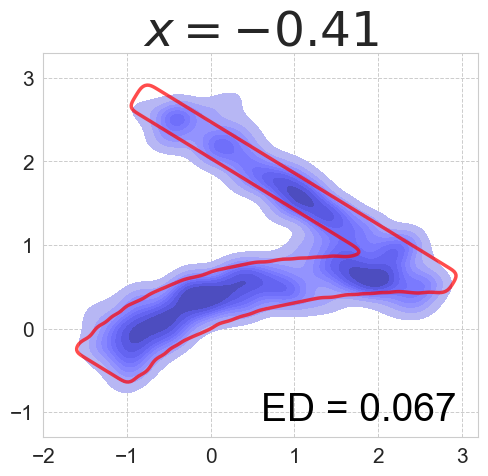

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
Y_true = gendata.create_c_slice(a=a, char_data=cdat)

sns.kdeplot(
    data=pd.DataFrame(Y_true), x=0, y=1, thresh=0.1, bw_adjust=0.2,
    levels=1, color='r', alpha=0.7, linewidths=2.5, zorder=2, ax=ax
)
sns.kdeplot(
    data=pd.DataFrame(points), weights=w_opt, levels=10,
    x=0, y=1, fill=True, zorder=1, ax=ax, bw_adjust=0.5, thresh=0.1, color='b'
)
ED = energy_distance(X=Y_true, Y=points, weight_Y=w_opt)
ax.text(0.6, -1.1, f'ED = {ED:.3f}', fontsize=28, color='k')
ax.set_aspect('equal', adjustable='box')

ax.set_xlim(-2, 3.2); ax.set_ylim(-1.3, 3.3)
ax.grid(True, linewidth=0.7, ls='--')
ax.set_xticks(np.arange(-2, 4, 1)); ax.set_yticks(np.arange(-1, 4, 1))

ax.set_title(r'$x={:.2f}$'.format(x), fontsize=35)
ax.tick_params(labelsize=15); ax.set_xlabel(None); ax.set_ylabel(None)
plt.tight_layout()
# plt.savefig('fg_c_tqf_blue.pdf', dpi=400)
plt.show()

In [51]:
%%time
for a in [0.35]:

    def shuffler(i: int):
    
        Y_shuffle = Y_true.copy()
        Y_shuffle[:, 1] = np.random.default_rng(i).permutation(Y_shuffle[:, 1])
    
        return Y_shuffle
    
    YY = np.concatenate([shuffler(j) for j in range(3)], axis=0)
    ED = energy_distance(X=Y_true, Y=YY)
    print(ED)

0.17367251212624424
CPU times: total: 5.19 s
Wall time: 5.23 s


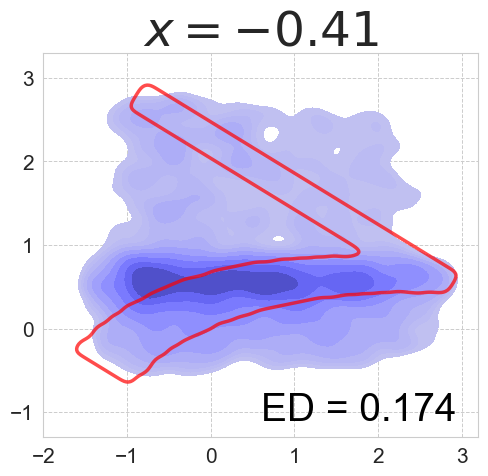

CPU times: total: 2.36 s
Wall time: 2.44 s


In [54]:
%%time
for a in [0.35]:    
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.kdeplot(
        data=pd.DataFrame(Y_true), x=0, y=1, thresh=0.1, bw_adjust=0.2,
        levels=1, color='r', alpha=0.7, linewidths=2.5, zorder=2, ax=ax
    )
    sns.kdeplot(
        data=pd.DataFrame(YY), levels=10,
        x=0, y=1, fill=True, zorder=1, ax=ax, bw_adjust=0.5, thresh=0.1, color='b'
    )
    
    ax.text(0.6, -1.1, f'ED = {ED:.3f}', fontsize=28, color='k')
    ax.set_aspect('equal', adjustable='box')

    ax.set_xlim(-2, 3.2); ax.set_ylim(-1.3, 3.3)
    ax.grid(True, linewidth=0.7, ls='--')
    ax.set_xticks(np.arange(-2, 4, 1)); ax.set_yticks(np.arange(-1, 4, 1))

    plt.title(r'$x={:.2f}$'.format(a2x(a)), fontsize=35)
    plt.tick_params(labelsize=15); plt.xlabel(None); plt.ylabel(None)
    plt.tight_layout()
    plt.savefig('fg_c_naive.pdf', dpi=400)
    plt.show()

In [55]:
def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        
        # eigenvalues (asc), eigenvectors as COLUMNS
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])

        # principal axis = first eigenvector (associated with smallest eigval)
        v = eig_vecs[:, 0]
        angle = np.degrees(np.arctan2(v[1], v[0]))  # radians -> degrees

        # Mahalanobis radius r = sqrt(2)  (= 63.2% mass)
        widths_heights = 2 * np.sqrt(2) * np.sqrt(eig_vals)  # [width, height]

        ell = mpl.patches.Ellipse(
            xy=means[n],
            width=widths_heights[0],
            height=widths_heights[1],
            angle=angle,
            edgecolor="black",
            facecolor="#56B4E9",
            alpha=weights[n] / max(weights)
        )
        ell.set_clip_box(ax.bbox)
        ax.add_patch(ell)

In [56]:
%%time
from sklearn.mixture import BayesianGaussianMixture
gm = BayesianGaussianMixture(n_components=1, max_iter=100, random_state=42).fit(Y_true)

CPU times: total: 0 ns
Wall time: 14.8 ms


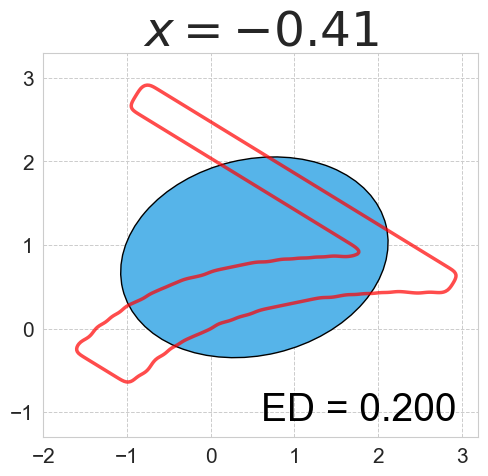

In [58]:
for a in [0.35]:

    fig, ax = plt.subplots(figsize=(5, 5))
    sns.kdeplot(
        data=pd.DataFrame(Y_true), x=0, y=1, thresh=0.1, bw_adjust=0.2,
        levels=1, color='r', alpha=0.7, linewidths=2.5, zorder=2, ax=ax
    )
    plot_ellipses(ax, gm.weights_, gm.means_, gm.covariances_)
    Y_gm, _ = gm.sample(n_samples=NN)
    ED = energy_distance(X=Y_true, Y=Y_gm)
    ax.text(0.6, -1.1, f'ED = {ED:.3f}', fontsize=28, color='k')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-2, 3.2); ax.set_ylim(-1.3, 3.3)
    ax.grid(True, linewidth=0.7, ls='--')
    ax.set_xticks(np.arange(-2, 4, 1)); ax.set_yticks(np.arange(-1, 4, 1))
    plt.tick_params(labelsize=15); plt.xlabel(None); plt.ylabel(None)
    plt.title(r'$x={:.2f}$'.format(a2x(a)), fontsize=35)
    plt.tight_layout()
    plt.savefig('fg_c_Gauss_1.pdf', dpi=400)
    plt.show()

In [59]:
%%time
from sklearn.mixture import BayesianGaussianMixture
gm = BayesianGaussianMixture(n_components=2, max_iter=100, random_state=42).fit(Y_true)

CPU times: total: 46.9 ms
Wall time: 54.2 ms


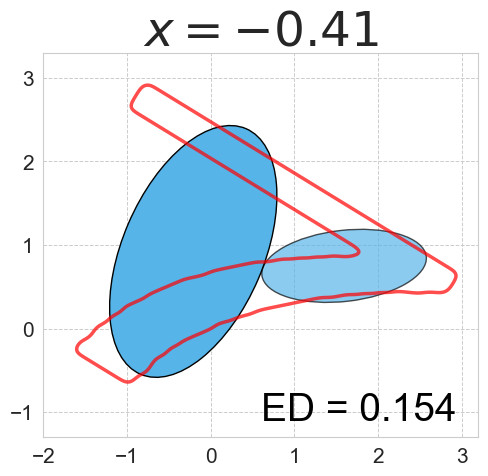

In [60]:
for a in [0.35]:

    fig, ax = plt.subplots(figsize=(5, 5))
    sns.kdeplot(
        data=pd.DataFrame(Y_true), x=0, y=1, thresh=0.1, bw_adjust=0.2,
        levels=1, color='r', alpha=0.7, linewidths=2.5, zorder=2, ax=ax
    )
    plot_ellipses(ax, gm.weights_, gm.means_, gm.covariances_)
    Y_gm, _ = gm.sample(n_samples=NN)
    ED = energy_distance(X=Y_true, Y=Y_gm)
    ax.text(0.6, -1.1, f'ED = {ED:.3f}', fontsize=28, color='k')
    ax.set_aspect('equal', adjustable='box')

    ax.set_xlim(-2, 3.2); ax.set_ylim(-1.3, 3.3)
    ax.grid(True, linewidth=0.7, ls='--')
    ax.set_xticks(np.arange(-2, 4, 1)); ax.set_yticks(np.arange(-1, 4, 1))

    plt.tick_params(labelsize=15); plt.xlabel(None); plt.ylabel(None)
    plt.title(r'$x={:.2f}$'.format(a2x(a)), fontsize=35)
    plt.tight_layout()
    plt.savefig('fg_c_Gauss_2.pdf', dpi=400)
    plt.show()

In [61]:
%%time
from sklearn.mixture import BayesianGaussianMixture
gm = BayesianGaussianMixture(n_components=3, max_iter=100, random_state=42).fit(Y_true)

CPU times: total: 46.9 ms
Wall time: 65.7 ms


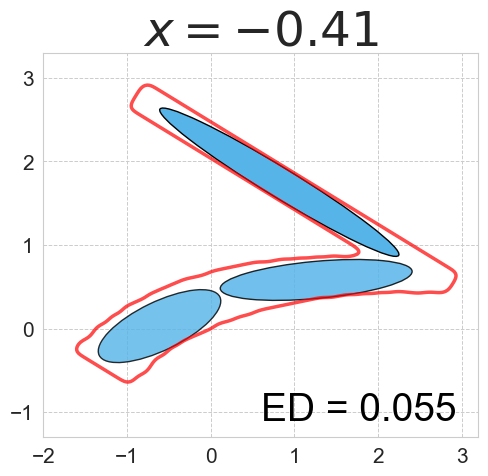

In [62]:
for a in [0.35]:

    fig, ax = plt.subplots(figsize=(5, 5))
    sns.kdeplot(
        data=pd.DataFrame(Y_true), x=0, y=1, thresh=0.1, bw_adjust=0.2,
        levels=1, color='r', alpha=0.7, linewidths=2.5, zorder=2, ax=ax
    )
    plot_ellipses(ax, gm.weights_, gm.means_, gm.covariances_)
    Y_gm, _ = gm.sample(n_samples=NN)
    ED = energy_distance(X=Y_true, Y=Y_gm)
    ax.text(0.6, -1.1, f'ED = {ED:.3f}', fontsize=28, color='k')
    ax.set_aspect('equal', adjustable='box')

    ax.set_xlim(-2, 3.2); ax.set_ylim(-1.3, 3.3)
    ax.grid(True, linewidth=0.7, ls='--')
    ax.set_xticks(np.arange(-2, 4, 1)); ax.set_yticks(np.arange(-1, 4, 1))

    plt.tick_params(labelsize=15); plt.xlabel(None); plt.ylabel(None)
    plt.title(r'$x={:.2f}$'.format(a2x(a)), fontsize=35)
    plt.tight_layout()
    plt.savefig('fg_c_Gauss_3.pdf', dpi=400)
    plt.show()